# Google Colab Setup

In [ ]:
#@title Setup Google Colab by running this cell only once (ignore this if run locally) {display-mode: "form"}
import sys

if 'google.colab' in sys.modules:
    # Clone GitHub repository
    !git clone https://github.com/epfl-exts/aiml2days.git
        
    # Copy files required to run the code
    !cp -r "aiml2days/notebooks/data" "aiml2days/notebooks/data_prep_tools.py" "aiml2days/notebooks/EDA_tools.py" "aiml2days/notebooks/modeling_tools.py" . 
    
    # Install packages via pip
    !pip install -r "aiml2days/colab-requirements.txt"
    
    # Restart Runtime
    import os
    os.kill(os.getpid(), 9)

# Build a spam detector

### Task 

We want to build a Spam detector which, given examples of spam emails (e.g. flagged by users) and examples of regular (non-spam, also called "ham") emails, learns how to flag new unseen emails as spam or non-spam.

### Data

In the previous notebooks we have covered the following steps:
* Load the data
* Text preprocessing
* Feature extraction
* Data exploration

The different feature sets can be loaded with the `load_feature_space()`-function. The options for the feature sets are:
* "num": numerical features
* "text": text features
* "num_text": numerical and text features combined
* "embedding": embedding features

### In this notebook

Our aim is to build a simple spam detector. We will start by exploring the different datasets, before we will build a simple spam detector and evaluate the model. We will use the following steps:
* Load the features
* Split the data into training and test set
* Train a simple spam detector
* Evaluate the model
* Analyze misclassified samples



In [1]:
# Load libraries and helper functions
%run data_prep_tools.py
%run EDA_tools.py
%run modeling_tools.py

## Load the data

We will just load the numerical features for now. The other feature sets will be loaded later.

In [2]:
num_features_df = load_feature_space("num", no_labels=False)
labels = load_labels()

Numeric features loaded
Data includes labels in the column 'spam_label'
The data set has 5832 rows, 14 columns
5832 labels loaded
Labels found: [1 0]


Let's check the number of samples per class in the data.

Samples per class (%):
non-spam    70.3
spam        29.7
Name: spam_label, dtype: float64




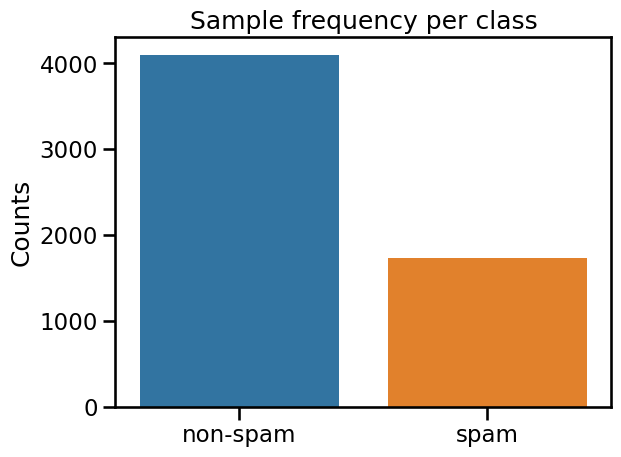

In [3]:
plot_class_frequency(labels)

<div class="alert alert-success">


<h3>Questions</h3>

Suppose you applied a **very naive approach** to the spam detection problem **that uses none of the features**: _You just either classify all emails as "spam" or as "non-spam"._

__Q1.__ How many emails would be classified correctly in each case?  

__Q2.__ Which approach would be more successful?

This naive kind of approach is useful to establish a **baseline** for the performance of our more complex classifiers.  
In this notebook we will build various spam detectors and compare their performance to this baseline.
</div>

#### Give your answer here:

1.    Predict all emails as spam:  29.7% correct  
      Predict all emails as non-spam:  70.3% correct  



2.    Predicting all emails as non-spam is more accurate. It is the most frequent class.  
      

# Model building

We are now ready to build our machine learning model for detecting spams. 

Throughout this notebook we will use a **Logistic Regression classifier**. Here is why:
- It is a simple and efficient model for binary classification tasks. 
- It is a good baseline for more complex models. 
- It is fast to train and thus allows us to quickly iterate on our model and try out different settings.
- It is also easy to interpret and allows us to explore where our model makes mistakes.

Below you will
- build a first simple model.
- tune the main hyperparameter `C` for the model using a cross-validated grid search.
- explore different feature sets and see how they affect the performance of the model.
- explore the effect of different evaluation metrics.
- Explore misclassified samples.

### A first trial

#### Training a single model

As a first trial, we will use the `num` feature set with a simpl. The accuracy is defined as the number of correct predictions divided by the total number of predictions.  

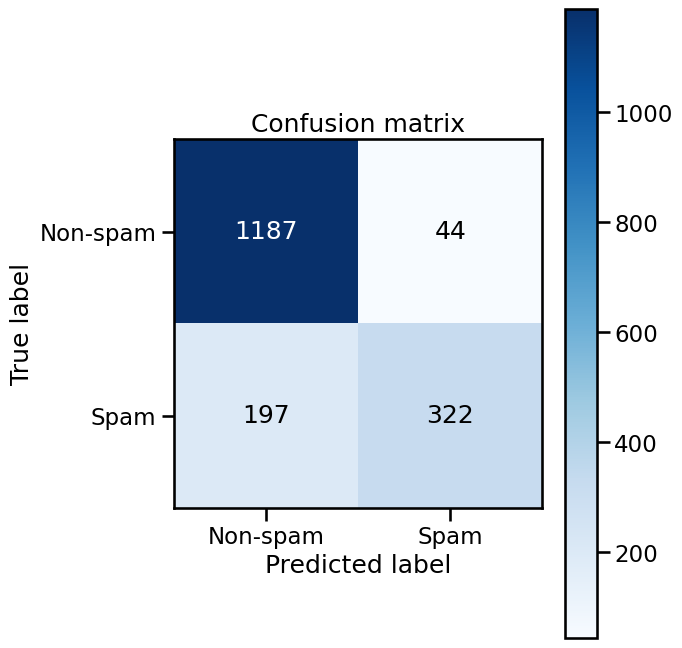

In [4]:
# Train/test splitting
df_train, df_test = train_test_split_(num_features_df)

# Fit model on the train data
model = fit_model(df_train, C=1)

# Print predictions on test set
plot_confusion_matrix(df_test, model)

<div class="alert alert-success">


<h3>Questions</h3>

Let's explore the plot above. 

__Q1.__ Which numbers tell use the correct predictions for each class?

__Q2.__ Which numbers tell use the failed predictions for each class?

__Q3.__ What class faired better?


</div>

#### Give your answer here:

1.    The horizontal axis shows the predicted class, the vertical axis shows the true class.  
Thus the numbers on the diagonal line show the number of correct predictions for each class.   
In our example we have: 1187 correct predictions for non-spam and 322 correct predictions for spam.  


2.    The numbers outside the diagonal line show the number of failed predictions for each class.  
The bottom left corner shows the number of true spam emails that were predicted as non-spam.
The top right corner shows the number of true non-spam emails that were predicted as spam.  
In our example we have:  
      - 44 failed predictions for non-spam 
      - 197 failed predictions for spam.




3.  The non-spam class faired better in absolute terms as it has a higher number of correct predictions (1187) compared to the spam class (322). Since the spam class has fewer samples, we should look at the relative numbers, i.e. the proportion of correct predictions of each class.

   - Non-spam: 1187 / (1187 + 44) = 0.964
   - Spam: 322 / (322 + 197) = 0.620

Note: Since the non-spam class is the majority class, it is easier to achieve a higher accuracy by predicting all emails as non-spam.


#### Classification report

The classification report provides us with different 4 metrics to evaluate the performance of our model.  
Support gives the total number of samples for each class in the test set.

3 metrics for per class:  
The **precision**  looks at the predictions per class. It divides the number of correct predictions by the number predictions made for that class. In the confusion matrix the emphasis is per column (vertical).

The **recall** looks at the ground truth per class. It divides the number of samples in that class that were correctly predicted by the number of samples in that class (support). In the confusion matrix  the emphasis is per column (horizontal).

The **f1-score** is the harmonic mean of precision and recall.

Overall metric:  
The **accuracy** is the number of all correct predictions divided by the total number of samples for the data set.



In [5]:
# Print classification report for test set
classification_report_(df_test, model)

              precision    recall  f1-score   support

    Non-spam       0.86      0.96      0.91      1231
        Spam       0.88      0.62      0.73       519

    accuracy                           0.86      1750
   macro avg       0.87      0.79      0.82      1750
weighted avg       0.86      0.86      0.85      1750



You can consider changing the `C` parameter in the `fit_model` function to see how it affects the model performance. But this is seen as bad practice be cause you are tuning the mmodel to the test set, which you also use for evaluation.

Instead let's use a more appropriate approach below.

### A more systematic approach:
#### Fine tuning with grid search and cross-validation

We will use 5-fold cross-validation. So the validation sets are automatically created internally. The test set will be used to `evaluate` the performance of our model. The process will automatically choose the best model for us. We also collect all the results from the cross-validation so we can plot them below.

In [6]:
# Train/test splitting
df_train, df_test = train_test_split_(num_features_df)
# text_features_df takes 45mins

# Fit model on the train data
model, cv_results = fit_log_reg_model(df_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


#### Tracking overfitting

Below we plot the results of the cross-validation. The x-axis shows the different values of `C` we tried, and the y-axis shows the metric of the model evaluated on the training set (blue) and on the validation set (orange). The red cross shows the value of the best `C` we found.

We are interested in the gap between the training and validation curves. If the gap is small, it means that our model is not overfitting and generalizes well to unseen data. If the gap is large, it means that our model is overfitting. This indicates that the model has learned irrelevant information like noise that does not reflect the general pattern. In such a case we need to find ways to adjust the model to reduce the gap and improve the performance on the validation set.

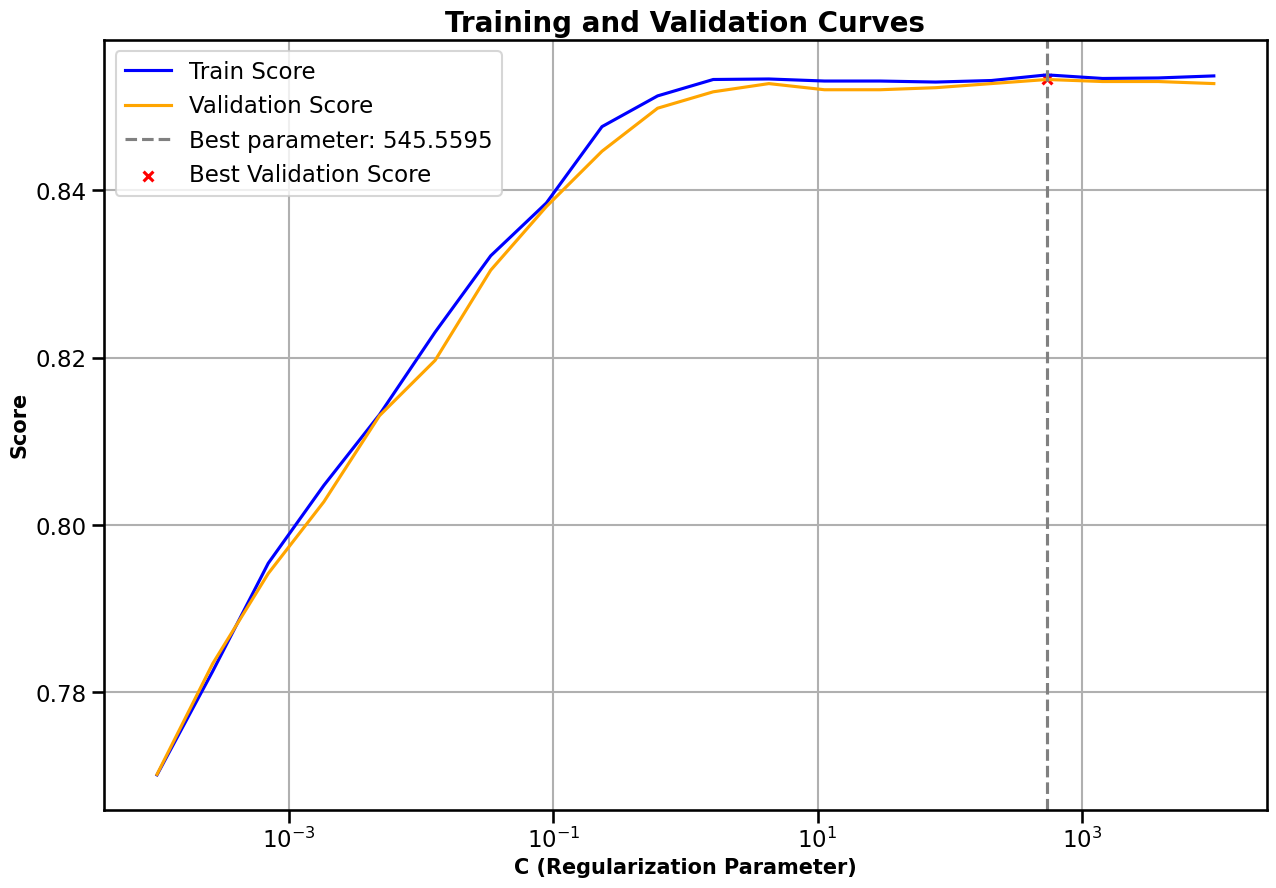

In [7]:
viz_cv_results(cv_results, show_table=False, plot_confidence=False, plot_fit_time=False)

<div class="alert alert-success">


<h3>Questions</h3>

Let's explore the plot above. 

__Q1.__ Do we observe overfitting i.e. a large gap between the training and validation curves?

__Q2.__ What happens when C is very small and when it is very large?


</div>

#### Give your answer here:

1.    The two curves track each other very closely. This indicates that the model is not overfitting and is generalizing well to unseen data.




2.    When we make C smaller the model performance decreases for both the training and validation sets. A small C values has a negative impact on performance of the related model and the model can't reach its learning capacity. We call this underfitting.  
From around C=1 upwards the performance plateaus. 







### Model evaluation

              precision    recall  f1-score   support

    Non-spam       0.86      0.96      0.91      1231
        Spam       0.88      0.62      0.73       519

    accuracy                           0.86      1750
   macro avg       0.87      0.79      0.82      1750
weighted avg       0.86      0.86      0.85      1750



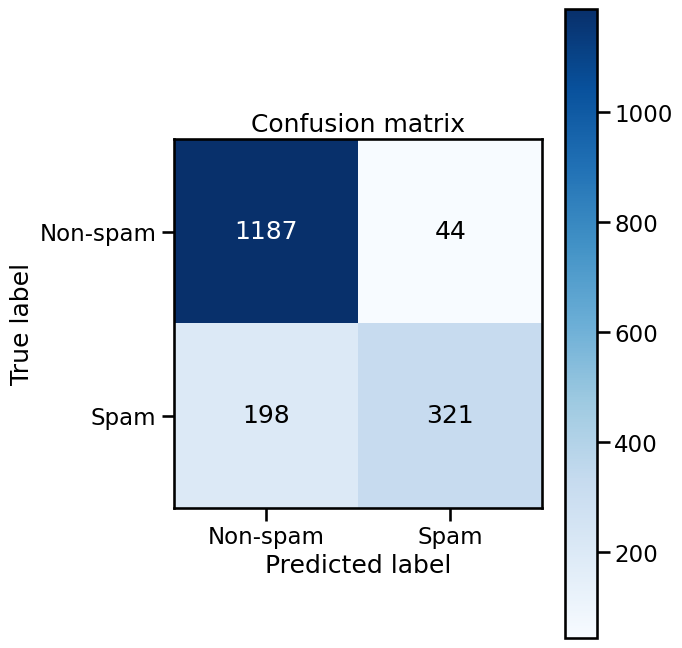

In [8]:
# Print classification report for test set
classification_report_(df_test, model)

# Print predictions on test set
plot_confusion_matrix(df_test, model)

### Get more insights into the model

In the Logistic Regression the coefficients tell us how much each feature contributes to the overall prediction. The larger the absolute value of a coefficient, the more important the corresponding feature is for the model. 

For the numerical features and the text features we always have positive feature values. Thus positive coefficients contribute more to the `spam` class while negative coefficients contribute more to the `non-spam` class.

For the embedding features we have both positive and negative feature values. Thus we need to look at the contributions (feature values times coefficients) to judge the impact on the overall prediction. This will help us understand the model's behavior better and identify which features are driving the predictions for particular samples.

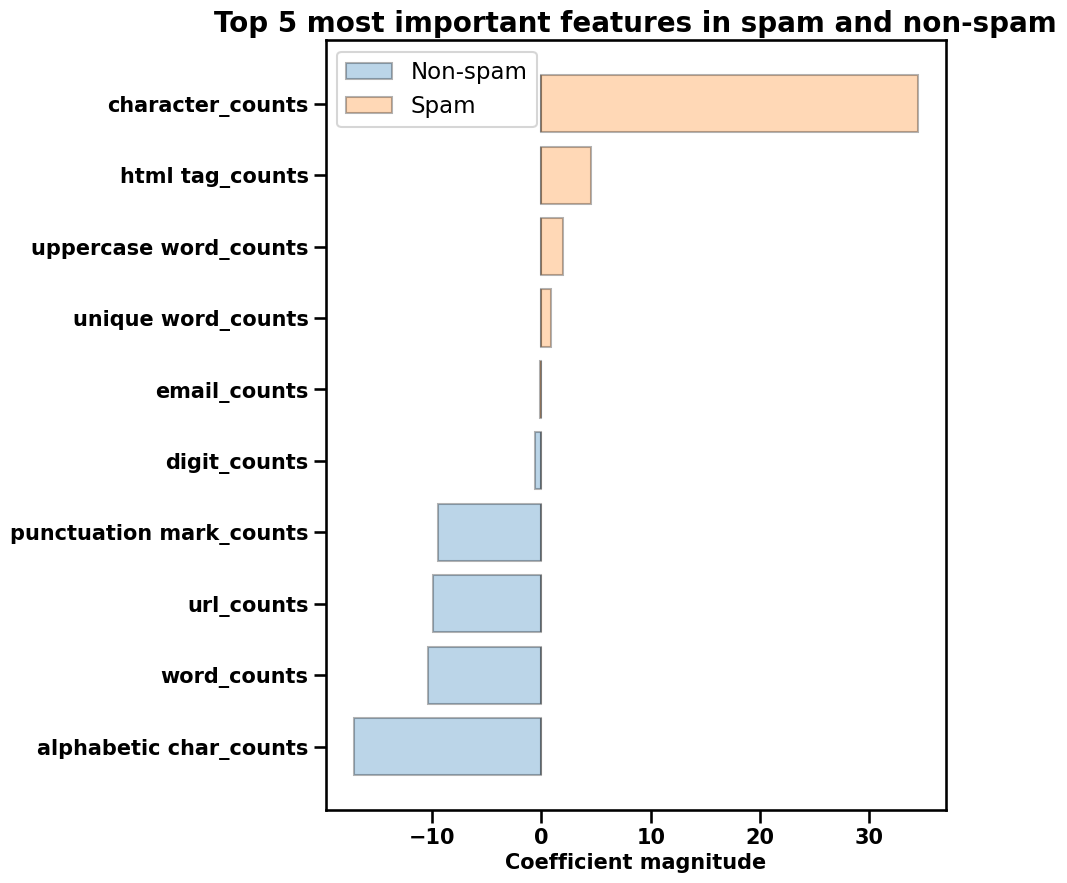

In [9]:
visualize_coefficients(model, df_train, n_top_features=5)

### How sure was the model of its predictions?
The Logistic Regression model can return the probabilities of each class for each sample. The probabilities are between 0 and 1, and the sum of the probabilities for each sample is 1. This allows us to assess the confidence of the model's predictions.

Below we plot the probabilities of the spam class and colour them by their actual class. Low probabilities (close to 0) indicate that the model is very sure that the sample is not spam, while high probabilities (close to 1) indicate that the model is very sure that the sample is spam.

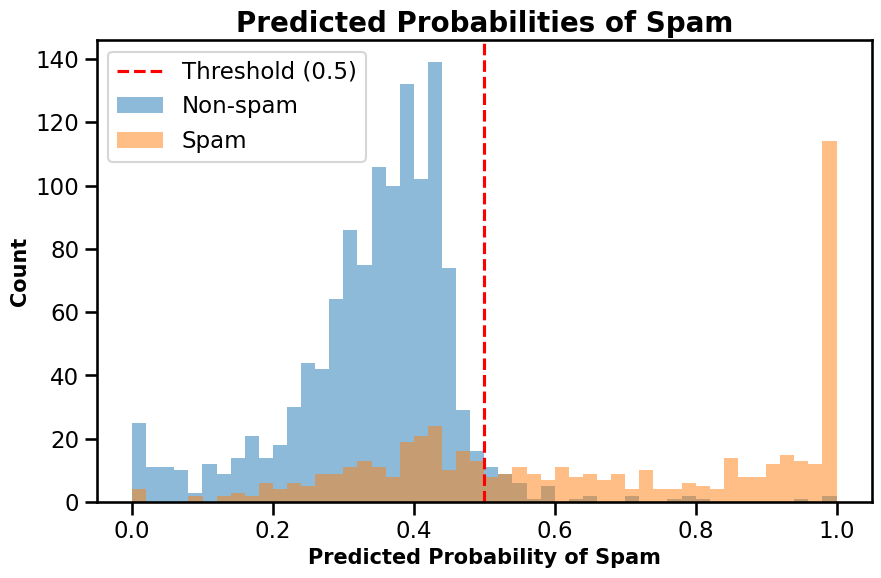

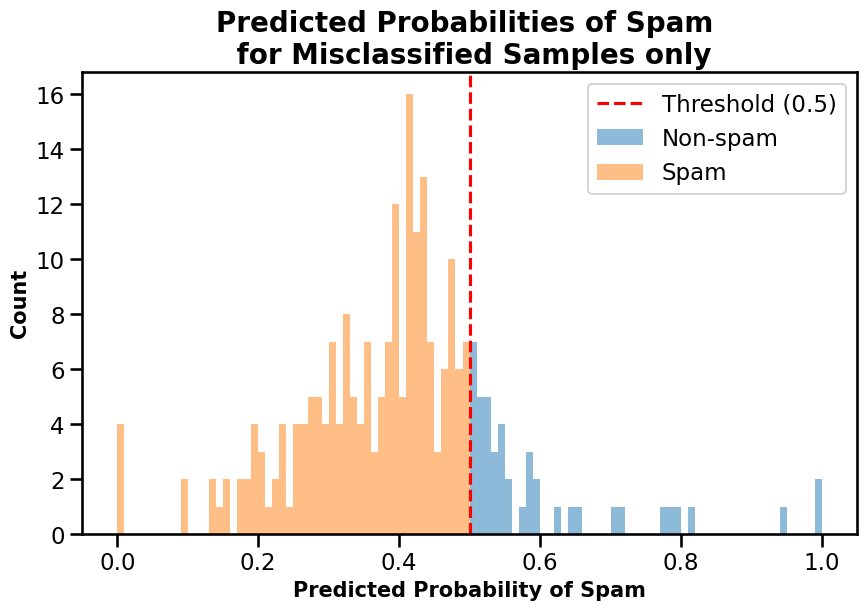

In [10]:
plot_prediction_certainties(df_test, model, log_scale=False)

<div class="alert alert-success">


<h3>Questions</h3>

Let's explore the plot above. 

__Q1.__ What do you observe for the distributions of each class?

__Q2.__ Focusing on the misclassified samples, was the model convinced of its predictions?  

Careful with interpretation if the top plot is using a log-scale. This means that the heights are not evenly spaced. You can change the setting.

</div>

#### Give your answer here:

__Q1.__ For the non-spam class the bulk of predictions are between 0.2 and 0.45. Very few are on the wrong side (above 0.5).

For the spam class, the model is very sure for 120 of the 519 spam samples (sharp peak near 1). The rest of the probabilities fairly uniformly distributed along the rest of the axis.

__Q2.__ For the misclassified non-spam samples, the model was mostly unsure and was close to being on the right side of 0.5. For the misclassified spam samples, the model was far more sure of its predictions, with many probabilities below 0.4, inline with the overall uniform distribution.


### Error analysis : Where does our model fail?

We will now analyze the misclassified mails in order to get some insights on where the model failed to make correct predictions. The *error_analysis* function below will show us the top features responsible for the model making a decision of prediction whether the mail is spam or non-spam.

Coefficients: 13
Number of misclassified samples: 242

Overview for document index: 10

Original Text
On Saturday, September 21, 2002, at 10:59 PM, Joseph S. Barrera III wrote: > Better yet, tell me
where I should be listening for new music now that > P2P is dead and I still can't pick up KFJC very
well. KFJC has a MP3 stream at kfjc.org. I'd also recommend radioparadise.com. I remember the
Suburban Lawns, but I don't know what became of them. Apropos of nothing: "Spirited Away" is
amazing. Go see it now. -- whump 

Cleaned Text
saturday september joseph barrera wrote better tell listening music dead pick kfjc kfjc stream kfjc
recommend radioparadise remember suburban lawns dont know apropos spirited away amazing whump 


Predictions

Actual class:   Non-spam
Predicted class:   Spam

Predicted probabilities
Non-spam: 0.4724
Spam: 0.5276



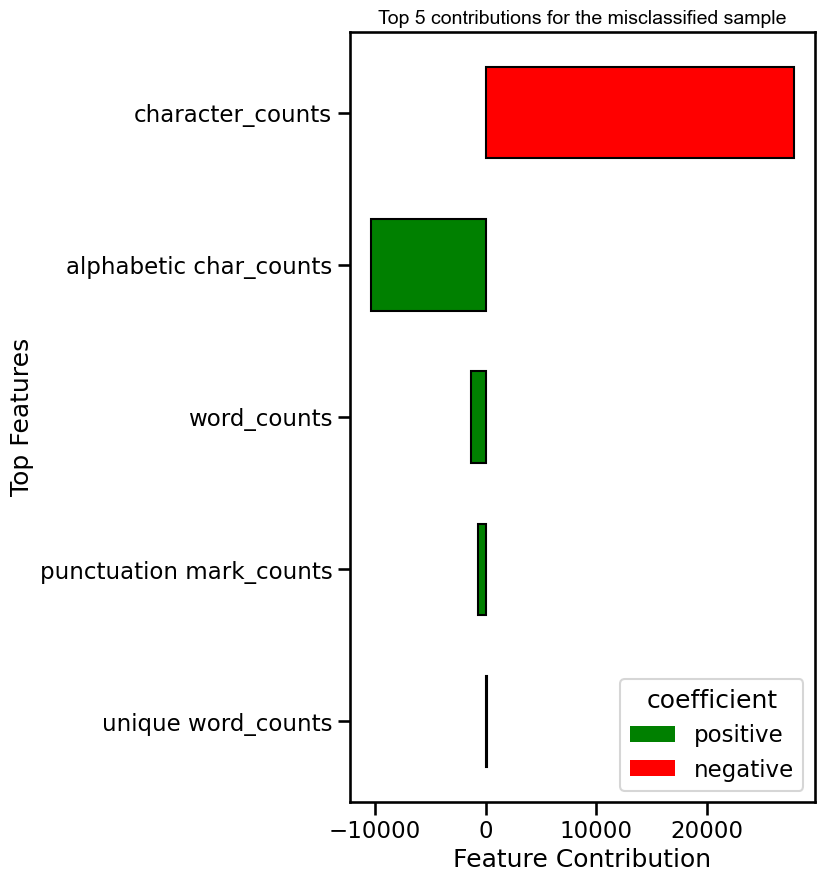

In [11]:
error_analysis(df_test, model, doc_nbr=10, n_top_coeff=5, color_by_coeff_sign=True)

<div class="alert alert-info">


# NOW IT'S YOUR TURN

We have copied the above code blocks again below. You can use them to build your own spam detector now. 

There are a number of things you can adapt:

### Change the feature space

We have loaded 4 feature spaces at the start of the notebook. Simply replace `num_features_df` with `text_features`, `num_text_features`, or `embedding_features` in the code below to use a different feature space.

Warning: The feature spaces using text features are quite slow (45 mins) and will take quite a while to run the fine-tuning with cross-validation.  
The pre-computed output of grid search with cross-validation can be loaded with the following code `pd.read_csv("text_log_reg_cv_results.csv")`
    
You can retrain the model using the `fit_model`-function with `C` set to the best `C`-value from `cv_results`.
    
### Change the metric used for fine-tuning

You can change the scoring function inside `fit_log_reg_model(df_train)`.  

The current default value is `None`, which means that the model will use the default scoring function for the Logistic Regression model. This is the accuracy score. 

However, you can also change the scoring function to `"precision"`, `"recall"`, or `"f1"` and check how the results change. More options are given [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

What happens to the confusion matrix as you vary the metric?

### Explore other settings

You will likely have to change some of the other parameters in the visualisations, etc. to make them more interpretable.

</div>

## Loading the other feature spaces

### Working locally on your machine
If you generated the text based features spaces in the notebook `data_preparation.ipynb` then you will be able to load them directly from the `data` folder.


In [12]:
# Load the remaining feature spaces
embeddings_df = load_feature_space("embedding", no_labels=False)
text_features_df = load_feature_space("text", no_labels=False)
num_text_features_df = load_feature_space("num_text", no_labels=False)

Email embeddings loaded
Data includes labels in the column 'spam_label'
The data set has 5832 rows, 769 columns
Text features (tfidf) loaded
Data includes labels in the column 'spam_label'
The data set has 5832 rows, 10001 columns
Text features (tfidf) loaded
Numeric and text features loaded
Data includes labels in the column 'spam_label'
The data set has 5832 rows, 10014 columns


### Working on Colab

If you are working on Google Colab, you will need to rerun the feature generation for text (code below) because the different notebooks don't share the same instance of the data folder

In [13]:
# Generate text features (this can take around 1:15 min)
df_source = load_source_data()
df_cleaned = clean_corpus(df_source)

text_features_df = extract_text_features(
    df_cleaned, vectorizer="tfidf", with_labels=True, store=True
)

text_features_df = load_feature_space("text", no_labels=False)
num_text_features_df = load_feature_space("num_text", no_labels=False)

8546 emails loaded
Cleaning data set:
2710 duplicate emails found and removed
4 empty emails found and removed

5832 emails remaining

Number of columns: 2
Columns names:
spam_label, text
Number of samples: 5832
Number of columns: 3
Columns names:
spam_label, text, text_cleaned

Number of duplicate cleaned texts found: 279
Number of empty texts found: 27

Email texts cleaned
Number of samples: 5832
TF-IDF Vectorizer selected
Text features saved to 'data/text_features_tfidf.csv'
Text features (tfidf) loaded
Data includes labels in the column 'spam_label'
The data set has 5832 rows, 10001 columns
Text features (tfidf) loaded
Numeric and text features loaded
Data includes labels in the column 'spam_label'
The data set has 5832 rows, 10014 columns


## Time to play

In [14]:
# To make things easier:
# Change your settings here and then run the cell below

feature_space = embeddings_df
# options are: num_features_df, text_features_df, num_text_features_df, embeddings_df


C = 1
# options to try are: 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000


scoring = None
# options include: 'accuracy', 'f1', 'precision', 'recall'

#### Single model

              precision    recall  f1-score   support

    Non-spam       1.00      0.98      0.99      1231
        Spam       0.95      0.99      0.97       519

    accuracy                           0.98      1750
   macro avg       0.97      0.98      0.98      1750
weighted avg       0.98      0.98      0.98      1750



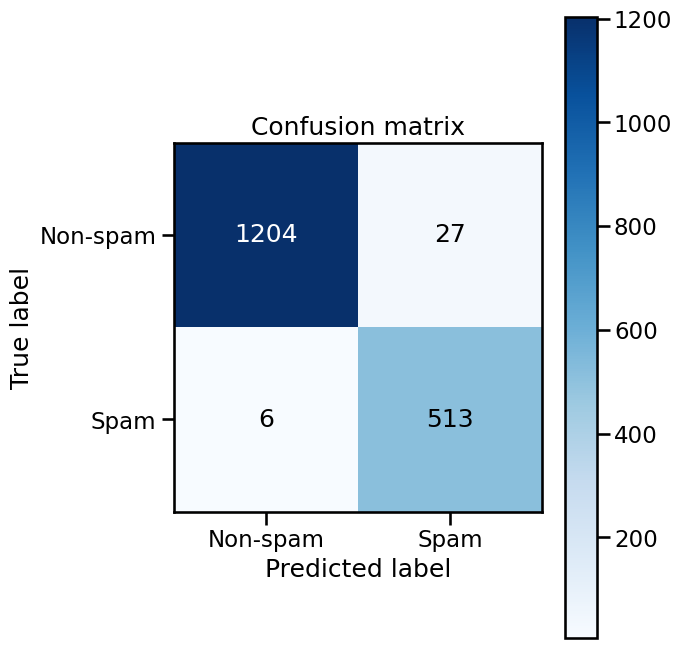

In [15]:
# Train/test splitting
df_train, df_test = train_test_split_(feature_space)

# Fit model on the train data
model = fit_model(df_train, C=C)

# Print classification report for test set
classification_report_(df_test, model)

# Print predictions on test set
plot_confusion_matrix(df_test, model)

#### Fine tuning with grid search and cross-validation

For text features this can take a while to run, so you can skip this step and load the pre-computed results from `text_log_reg_cv_results.csv` and rerun `fit_model` with the best `C`-value you found.

In [16]:
# Train/test splitting
df_train, df_test = train_test_split_(feature_space)

# Fit model on the train data
model, cv_results = fit_log_reg_model(df_train, scoring=scoring)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


##### Load fine tuning results for text features

In [17]:
# For text features only
cv_results = pd.read_csv("text_log_reg_cv_results.csv")

In [18]:
# Fix C
C = 1

model = fit_model(df_train, C=C)

#### Tracking overfitting for all cases

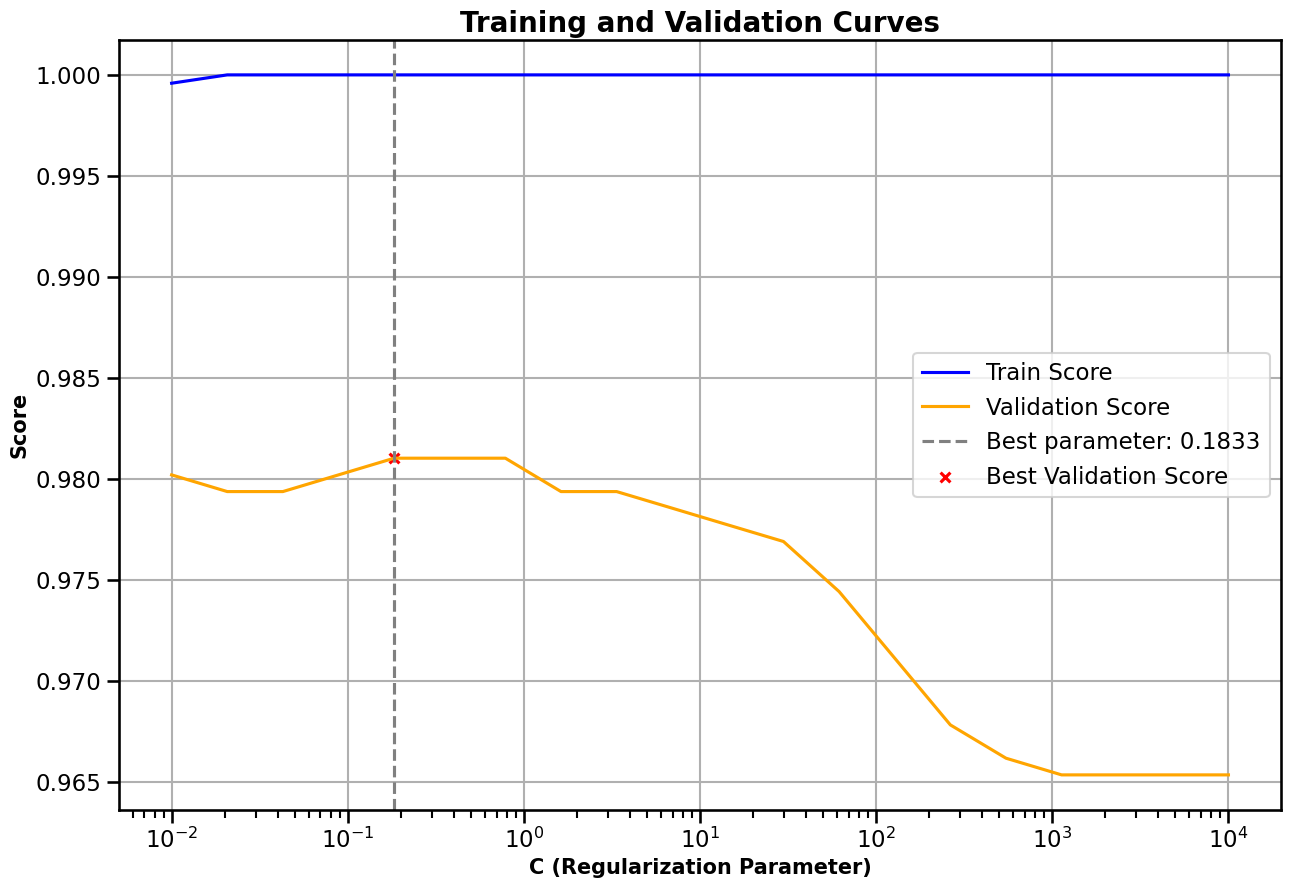

In [19]:
viz_cv_results(cv_results, show_table=False, plot_confidence=False, plot_fit_time=False)

### Model evaluation

              precision    recall  f1-score   support

    Non-spam       1.00      0.98      0.99      1231
        Spam       0.95      0.99      0.97       519

    accuracy                           0.98      1750
   macro avg       0.97      0.98      0.98      1750
weighted avg       0.98      0.98      0.98      1750



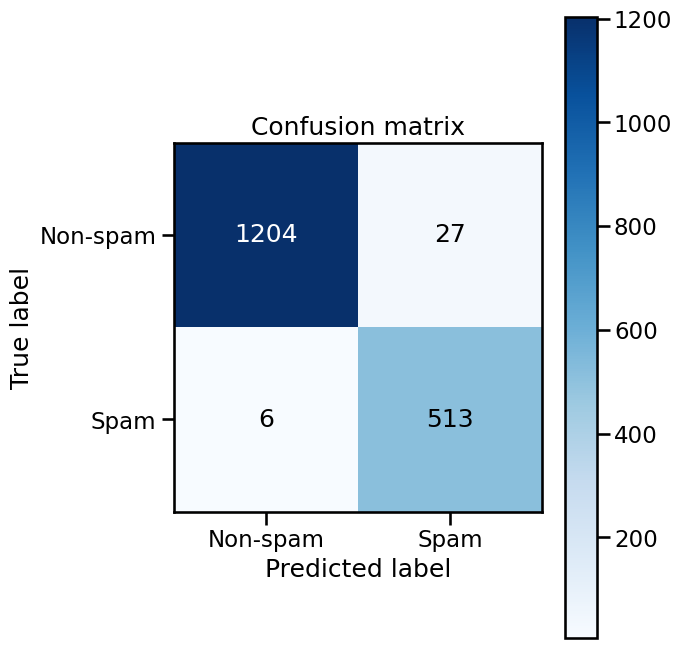

In [20]:
# Print classification report for test set
classification_report_(df_test, model)

# Print predictions on test set
plot_confusion_matrix(df_test, model)

### Get more insights into the model

In [21]:
visualize_coefficients(model, df_train, n_top_features=10)

AttributeError: 'LogisticRegression' object has no attribute 'named_steps'

### How sure was the model of its predictions?


In [ ]:
plot_prediction_certainties(df_test, model, log_scale=True)

### Error analysis :: Where does our model fail?

In [ ]:
error_analysis(df_test, model, doc_nbr=10, n_top_coeff=15, color_by_coeff_sign=True)